# Inscopix CNMFe Demo

This notebook demonstrates how to use the Inscopix CNMFe package to extract and visualize the spatial footprints and temporal dynamics of neurons in a 1-photon calcium imaging movie recorded in the mouse dorsal striatum. Before using this notebook, you will need to install the dependencies listed below:

`pip install inscopix-cnmfe scikit-image pandas matplotlib`

In [1]:
# Import required packages
import inscopix_cnmfe
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

In [2]:
# Run cnmfe on a sample movie
inscopix_cnmfe.run_cnmfe(
    input_movie_path='test/data/movie.tif', 
    output_dir_path='output', 
    output_filetype=0,
    average_cell_diameter=7,
    min_corr=0.8,
    min_pnr=10.0,
    gaussian_kernel_size=0,
    closing_kernel_size=0,
    background_downsampling_factor=2,
    ring_size_factor=1.4,
    merge_threshold=0.7,
    num_threads=4,
    processing_mode=2,
    patch_size=80,
    patch_overlap=20,
    trace_output_units=1
)

[2021-10-28 12:06:25.638][Inscopix CNMFe][SYSTEM] Inscopix CNMFe version: 1.0.0
[2021-10-28 12:06:25.638][Inscopix CNMFe][SYSTEM] Operating system: Mac OSX
[2021-10-28 12:06:25.644][Inscopix CNMFe][SYSTEM] Number of cores: 16
[2021-10-28 12:06:25.644][Inscopix CNMFe][INFO] CNMFe parameters:
{
    "averageCellDiameter": 7,
    "backgroundDownsamplingFactor": 2,
    "closingKernelSize": 0,
    "gaussianKernelSize": 0,
    "inputMoviePath": "test/data/movie.tif",
    "mergeThreshold": 0.699999988079071,
    "minCorr": 0.800000011920929,
    "minPnr": 10,
    "numThreads": 4,
    "outputDirPath": "output",
    "outputFiletype": 0,
    "patchOverlap": 20,
    "patchSize": 80,
    "processingMode": 2,
    "ringSizeFactor": 1.39999997615814,
    "traceOutputUnits": 1
}
[2021-10-28 12:06:25.644][Inscopix CNMFe][INFO] Loading tiff input (file: test/data/movie.tif)
[2021-10-28 12:06:25.644][Inscopix CNMFe][INFO] Using parallel patches processing mode
[2021-10-28 12:06:25.644][Inscopix CNMFe][INF

In [3]:
# Read and load footprints and traces into memory
footprints = io.imread('output/movie_footprints.tiff')
traces = pd.read_csv('output/movie_traces.csv')

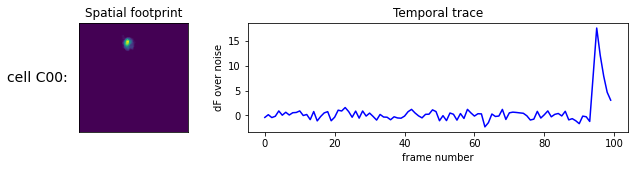

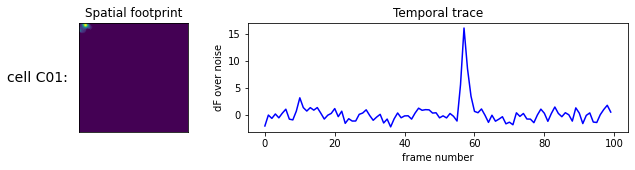

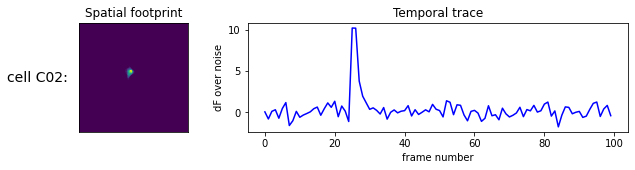

In [4]:
# Visualize the spatial footprint and temporal dynamics of neurons identified using CNMFe

# number of neurons we wish to visualize
num_neurons = 3

for neuron_index in range(num_neurons):
    neuron_name = traces.columns[neuron_index + 1]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 3]})

    # spatial footprint
    axes[0].imshow(footprints[neuron_index])
    axes[0].set_title("Spatial footprint")
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # temporal dynamics
    axes[1].set_title("Temporal trace")
    axes[1].plot(traces[neuron_name], label='neuron {0}'.format(neuron_name), color='blue')
    axes[1].set_ylabel("dF over noise")
    axes[1].set_xlabel("frame number")
    
    plt.suptitle(
        'cell {0}:'.format(neuron_name), 
        x=0.08,
        y=0.55,
        fontsize=14
    )

    plt.show()